In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
class EEGTransformer(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, hidden_dim, num_classes):
        super(EEGTransformer, self).__init__()
        
        # Transformer的编码器部分
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim),
            num_layers=num_layers
        )
        
        # 通过一个全连接层将Transformer的输出映射到最终的类别数
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # 输入数据x的形状是(batch_size, seq_len, features)
        # 转置数据以符合Transformer要求的形状 (seq_len, batch_size, features)
        x = x.permute(1, 0, 2)
        
        # 通过Transformer编码器
        x = self.encoder(x)
        
        # 只取序列的最后一步的输出进行分类
        x = x[-1, :, :]
        
        # 通过全连接层输出分类结果
        x = self.fc(x)
        return x

In [ ]:
# 定义模型训练函数
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device).float(), labels.to(device)  # 转换为float32

        inputs = inputs.contiguous() # 确保输入张量是连续的
        optimizer.zero_grad()  # 清除之前的梯度
        outputs = model(inputs)  # 进行前向传播
        
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重
        
        running_loss += loss.item()
        
        # 计算准确率
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total * 100
    return epoch_loss, epoch_acc

# 定义模型测试函数
def test_model(model, test_loader, device):
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0
    
    with torch.no_grad():  # 在测试时不需要计算梯度
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.contiguous()  
            inputs = inputs.float() 
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return accuracy

In [ ]:
# 定义主函数
def main(train_loader, val_loader, test_loader, device, num_epochs=10):

    features = 128
    num_classes = 2  # 2个类别
    num_heads = 4  # 多头注意力头数
    num_layers = 4  # Transformer的层数
    hidden_dim = 512  # 前馈网络的隐藏层维度

    # 创建模型实例
    model = EEGTransformer(input_dim=features, num_heads=num_heads, num_layers=num_layers, hidden_dim=hidden_dim, num_classes=num_classes)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # 使用Adam优化器
    
    train_accuracies = []
    val_accuracies = []
    train_losses = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # 训练模型
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # 在验证集上测试模型
        val_acc = test_model(model, val_loader, device)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Validation Accuracy: {val_acc:.2f}%\n")
    
    # 测试模型
    test_acc = test_model(model, test_loader, device)
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    # 绘制训练过程中训练准确率的变化
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
    plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

    # 绘制训练损失的变化
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.show()

C:\Users\24735\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10


C:\Users\24735\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Train Loss: 0.3035, Train Accuracy: 85.80%
Validation Accuracy: 98.15%

Epoch 2/10
Train Loss: 0.0700, Train Accuracy: 97.92%
Validation Accuracy: 99.66%

Epoch 3/10
Train Loss: 0.0318, Train Accuracy: 99.14%
Validation Accuracy: 98.49%

Epoch 4/10
Train Loss: 0.0137, Train Accuracy: 99.57%
Validation Accuracy: 97.15%

Epoch 5/10
Train Loss: 0.0346, Train Accuracy: 99.21%
Validation Accuracy: 99.50%

Epoch 6/10
Train Loss: 0.0372, Train Accuracy: 98.99%
Validation Accuracy: 99.83%

Epoch 7/10
Train Loss: 0.0221, Train Accuracy: 99.35%
Validation Accuracy: 99.50%

Epoch 8/10
Train Loss: 0.0190, Train Accuracy: 99.42%
Validation Accuracy: 97.48%

Epoch 9/10
Train Loss: 0.0265, Train Accuracy: 99.25%
Validation Accuracy: 99.83%

Epoch 10/10
Train Loss: 0.0024, Train Accuracy: 99.96%
Validation Accuracy: 99.50%

Test Accuracy: 99.66%


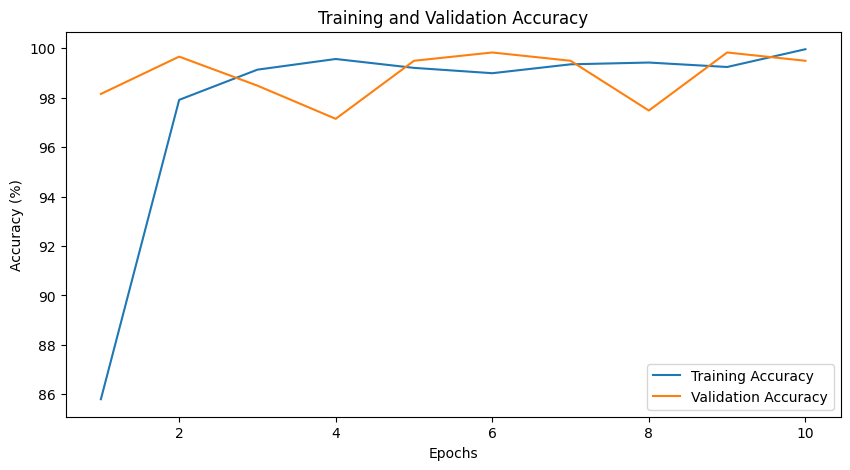

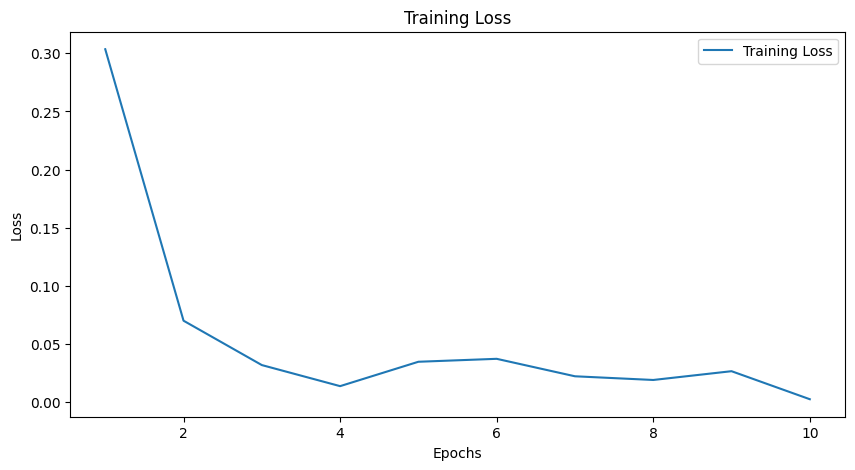

In [ ]:
# 设置gpu训练
device = torch.device("cuda")

train_loader = torch.load('../data/Dataloader_1D/train_loader.pth')
val_loader = torch.load('../data/Dataloader_1D/val_loader.pth')
test_loader = torch.load('../data/Dataloader_1D/test_loader.pth')

# 运行训练和测试
main(train_loader, val_loader, test_loader, device, num_epochs=10)